# Demo Catalog Workflow

There are 3 optional catalogs that this class manages:

1. source: combined catalog for all available models from hard-wired info in source_catalogs
1. updated: optional combined catalog for all or subset of available models. Benefit of using
    this is that some specific metadata is read in from the forecast-version of the models
    themselves, which may be useful for deciding which model to use. This is most useful for the aggregated forecast models since all available dates will be automatically included.
1. user: this catalog contains only the one or few specific model setups for a user project.


Current Status:
* this code is working
* docstrings filled out
* tests written and run

Next steps:
* move the code to https://github.com/NOAA-ORR-ERD/LibGOODS
* Amy and Chris try it out and give feedback
* a few minor updates to make specific catalogs work more generally
* add NAM
* Set up readthedocs for this work? How would that work with the existing repo setup?
* any interest in offering this as a separate package? In my past worklife I would have like to use this and other might too! (though also could get through your established github repo)


In [1]:
import model_catalogs as mc

import intake
import pandas as pd

import os

## Set up GOODS catalogs

### Make source catalog

Check out the catalog files used in the source catalog in `catalogs/source_catalogs/`. This has all been hard-wired in and is where a new model would need to be added.

Initialize the Management class and get `cats.source_cat`.

In [2]:
%%time
cats = mc.Management(make_source_catalog=True)

CPU times: user 201 ms, sys: 13 ms, total: 214 ms
Wall time: 226 ms


Look at the catalog-level metadata for `source_cat`:

In [3]:
cats.source_cat

../catalogs/source_catalogs/source_catalog.yaml:
  args:
    description: Source catalog for models.
    name: ../catalogs/source_catalogs/source_catalog.yaml
  description: Source catalog for models.
  driver: intake.catalog.base.Catalog
  metadata:
    source_catalog_dir: ../catalogs/source_catalogs/orig


List all the models available in `source_cat`:

In [4]:
list(cats.source_cat)

['TBOFS',
 'RTOFS-East',
 'RTOFS-Global',
 'GFS-1deg',
 'GFS-1_2deg',
 'NYOFS',
 'NGOFS2',
 'LMHOFS',
 'RTOFS-Alaska',
 'LSOFS',
 'CBOFS',
 'WCOFS',
 'LOOFS',
 'SFBOFS',
 'LEOFS',
 'DBOFS',
 'RTOFS-West',
 'HYCOM',
 'GOMOFS',
 'CIOFS',
 'CREOFS',
 'GFS-1_4deg']

Look at a given model's subcatalog-level metadata, which can be accessed each by name

In [5]:
cats.source_cat['TBOFS']

TBOFS:
  args:
    path: ../catalogs/source_catalogs/orig/ref_tbofs.yaml
  description: Tampa Bay model in ROMS.
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: ''
    grid_dim_(xyz):
    - 176
    - 290
    - 11
    grid_res_max_(km): 1.2
    grid_res_min_(km): 0.1
    grid_type: curvilinear


Get metadata properties for model:

In [6]:
cats.source_cat['TBOFS'].metadata['grid_type']

'curvilinear'

For a given model, list the timing options available:

In [7]:
list(cats.source_cat['TBOFS'])

['forecast', 'nowcast', 'hindcast', 'hindcast-forecast-aggregation']

Examine one of the subcatalogs:

In [8]:
cats.source_cat['TBOFS','forecast']
# equivalent to `cats.source_cat['TBOFS']['forecast']` or
# `cats.source_cat.TBOFS.forecast`

forecast:
  args:
    chunks:
      ocean_time: 1
    drop_variables:
    - ocean_time
    engine: netcdf4
    urlpath: https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/TBOFS/fmrc/Aggregated_7_day_TBOFS_Fields_Forecast_best.ncd
  description: 3D Tampa Bay model in ROMS with 48 hour forecast.
  driver: intake_xarray.opendap.OpenDapSource
  metadata:
    catalog_dir: /Users/kthyng/projects/LibGOODS/model_catalogs/notebooks/../catalogs/source_catalogs/orig/
    overall_end_datetime: 48 hours after present time
    overall_start_datetime: 7 days before present time


Or get metadata properties for model timing:

In [9]:
cats.source_cat['TBOFS','forecast'].metadata['overall_end_datetime']

'48 hours after present time'

If a model has a static URL, you can open it now. Otherwise you need to wait for either the "updated catalog" or the "user" catalog. This one has a static URL so we can open it. Note that once you have run this command, you can subsequently find the xarray Dataset at `cats.source_cat['TBOFS','forecast']._ds`.

In [10]:
cats.source_cat['TBOFS','forecast'].to_dask()

<xarray.Dataset>
Dimensions:          (s_rho: 11, s_w: 12, eta_rho: 290, xi_rho: 176,
                      eta_u: 290, xi_u: 175, eta_v: 289, xi_v: 176,
                      eta_psi: 289, xi_psi: 175, time: 240, tracer: 2,
                      boundary: 4)
Coordinates:
  * s_rho            (s_rho) float64 -0.9545 -0.8636 ... -0.1364 -0.04545
  * s_w              (s_w) float64 -1.0 -0.9091 -0.8182 ... -0.1818 -0.09091 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 175), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 175), meta=np.ndarray>
    lon_v            (eta_v, xi_v) float64 dask.array<chunksize=(289, 176), meta=np.ndarray>
    lat_v            (eta_v, xi_v) float64 dask.array<chunksize=(289, 176), meta=np.ndarray>
    lon_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(289, 175), meta=np.ndarray>
    lat_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(289, 175), meta=np.ndarray>
  * time             (time) datetime64[ns] 2022-02-09T19:00:00 ... 2022-02-19...
    time_run         (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v,
                                eta_psi, xi_psi, tracer, boundary
Data variables: (12/83)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    nHIS             int32 ...
    ...               ...
    temp             (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 11, 290, 176), meta=np.ndarray>
    salt             (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 11, 290, 176), meta=np.ndarray>
    Pair             (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 290, 176), meta=np.ndarray>
    Uwind            (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 290, 176), meta=np.ndarray>
    Vwind            (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 290, 176), meta=np.ndarray>
    time_offset      (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Attributes: (12/39)
    file:                            nos.tbofs.fields.forecast.20220216.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           TBOFS - Tampa Bay Operational Forecast S...
    var_info:                        varinfo.dat
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_7_day_TBOFS_Fields...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               11

In [11]:
cats.source_cat['TBOFS','forecast']._ds

<xarray.Dataset>
Dimensions:          (s_rho: 11, s_w: 12, eta_rho: 290, xi_rho: 176,
                      eta_u: 290, xi_u: 175, eta_v: 289, xi_v: 176,
                      eta_psi: 289, xi_psi: 175, time: 240, tracer: 2,
                      boundary: 4)
Coordinates:
  * s_rho            (s_rho) float64 -0.9545 -0.8636 ... -0.1364 -0.04545
  * s_w              (s_w) float64 -1.0 -0.9091 -0.8182 ... -0.1818 -0.09091 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 175), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 175), meta=np.ndarray>
    lon_v            (eta_v, xi_v) float64 dask.array<chunksize=(289, 176), meta=np.ndarray>
    lat_v            (eta_v, xi_v) float64 dask.array<chunksize=(289, 176), meta=np.ndarray>
    lon_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(289, 175), meta=np.ndarray>
    lat_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(289, 175), meta=np.ndarray>
  * time             (time) datetime64[ns] 2022-02-09T19:00:00 ... 2022-02-19...
    time_run         (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v,
                                eta_psi, xi_psi, tracer, boundary
Data variables: (12/83)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    nHIS             int32 ...
    ...               ...
    temp             (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 11, 290, 176), meta=np.ndarray>
    salt             (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 11, 290, 176), meta=np.ndarray>
    Pair             (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 290, 176), meta=np.ndarray>
    Uwind            (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 290, 176), meta=np.ndarray>
    Vwind            (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 290, 176), meta=np.ndarray>
    time_offset      (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Attributes: (12/39)
    file:                            nos.tbofs.fields.forecast.20220216.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           TBOFS - Tampa Bay Operational Forecast S...
    var_info:                        varinfo.dat
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_7_day_TBOFS_Fields...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               11

### Make updated catalog (optional)

Use already-existing source catalog and make updated catalog. This by default runs through all available models, ands looks at either the aggregated forecast model output or two sample nowcast files for today to calculate some metadata and save the model output attributes. For the aggregated forecast models, newly found metadata attributes `calculated_start_datetime` and `calculated_end_datetime` are accurate as to what forecast range is currently available. For the unaggregated models, this information is not accurate. The `overall_start_datetime` and `overall_end_datetime` metadata attributes shown above contain hard-wired descriptive information about each timing range that should be useful.

In [12]:
%%time
cats.updated_cat

/Users/kthyng/miniconda3/envs/model_catalogs/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/kthyng/miniconda3/envs/model_catalogs/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/kthyng/miniconda3/envs/model_catalogs

CPU times: user 2min 1s, sys: 2.17 s, total: 2min 3s
Wall time: 3min 16s


../catalogs/updated_catalogs/2022-02-17T17:01:37.741403/updated_catalog.yaml:
  args:
    description: Updated catalog for models.
    name: ../catalogs/updated_catalogs/2022-02-17T17:01:37.741403/updated_catalog.yaml
  description: Updated catalog for models.
  driver: intake.catalog.base.Catalog
  metadata:
    source_catalog_dir: ../catalogs/source_catalogs/orig
    source_catalog_name: ../catalogs/source_catalogs/source_catalog.yaml
    updated_catalog_dir: ../catalogs/updated_catalogs/2022-02-17T17:01:37.741403


Since I didn't specify a subset of model names to use in the updated catalog, all of the models are available here:

In [13]:
list(cats.updated_cat)

['TBOFS',
 'RTOFS-East',
 'RTOFS-Global',
 'GFS-1deg',
 'GFS-1_2deg',
 'NYOFS',
 'NGOFS2',
 'LMHOFS',
 'RTOFS-Alaska',
 'LSOFS',
 'CBOFS',
 'WCOFS',
 'LOOFS',
 'SFBOFS',
 'LEOFS',
 'DBOFS',
 'RTOFS-West',
 'HYCOM',
 'GOMOFS',
 'CIOFS',
 'CREOFS',
 'GFS-1_4deg']

With the newly-found model metadata, we can look at boundaries of a model:
    
High resolution (concave hull):

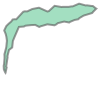

In [14]:
import shapely.wkt

P = shapely.wkt.loads(cats.updated_cat['NGOFS2'].metadata['geospatial_bounds_high'])
P

Low resolution (convex hull):

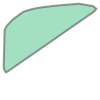

In [15]:
P = shapely.wkt.loads(cats.updated_cat['NGOFS2'].metadata['geospatial_bounds_low'])
P

Bounding box:

In [16]:
cats.updated_cat['NGOFS2'].metadata['bounding_box']

[262.1380310058594, 21.789426803588867, 274.26678466796875, 30.780752182006836]

Look at forecast timing:

In [17]:
cats.updated_cat['CBOFS','forecast'].metadata['calculated_start_datetime'], \
cats.updated_cat['CBOFS','forecast'].metadata['calculated_end_datetime']

('2022-02-09T19:00:00.000000000', '2022-02-19T18:00:00.000000000')

### User-created catalog

A user setting up a project would here specify the exact model output they want to use and this is stored in the `user_cat`. You can specify one or multiple models. Here let's say you want to compare:
* aggregated-by-NOAA "fields" (3D unstructured) forecast
* aggregated-by-code "fields" forecast
* aggregated-by-code "regulargrid" forecast

In [18]:
%%time
today = pd.Timestamp.today()
yesterday = today - pd.Timedelta('1 day')

cats.setup_user_cat([dict(model='DBOFS', 
                          timing='forecast', 
                          start_date=None, 
                          end_date=None,
                          filetype='fields', 
                          treat_last_day_as_forecast=False),
                     dict(model='DBOFS', timing='nowcast', 
                          start_date=yesterday, end_date=today,
                          filetype='fields', 
                          treat_last_day_as_forecast=True),
                     dict(model='DBOFS', timing='nowcast', 
                          start_date=yesterday, end_date=today,
                          filetype='regulargrid', 
                          treat_last_day_as_forecast=True),
                    ])


CPU times: user 605 ms, sys: 23.2 ms, total: 629 ms
Wall time: 2.64 s


In [19]:
list(cats.user_cat)

['DBOFS-forecast',
 'DBOFS-nowcast-fields-with_forecast',
 'DBOFS-nowcast-regulargrid-with_forecast']

In [20]:
cats.user_cat['DBOFS-forecast'].to_dask()

<xarray.Dataset>
Dimensions:        (s_rho: 10, s_w: 11, eta_rho: 732, xi_rho: 119, eta_u: 732,
                    xi_u: 118, eta_v: 731, xi_v: 119, eta_psi: 731,
                    xi_psi: 118, time: 240, tracer: 2, boundary: 4)
Coordinates:
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
  * time           (time) datetime64[ns] 2022-02-09T19:00:00 ... 2022-02-19T1...
    time_run       (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v,
                                eta_psi, xi_psi, tracer, boundary
Data variables: (12/80)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    temp           (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 10, 732, 119), meta=np.ndarray>
    salt           (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 10, 732, 119), meta=np.ndarray>
    Pair           (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 732, 119), meta=np.ndarray>
    Uwind          (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 732, 119), meta=np.ndarray>
    Vwind          (time, eta_rho, xi_rho) float32 dask.array<chunksize=(240, 732, 119), meta=np.ndarray>
    time_offset    (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Attributes: (12/39)
    file:                            nos.dbofs.fields.forecast.20220216.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           DBOFS - Delaware Bay Operational Forecas...
    var_info:                        varinfo.dat
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_7_day_DBOFS_Fields...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               10

In [21]:
cats.user_cat['DBOFS-forecast']._ds['time']

<xarray.DataArray 'time' (time: 240)>
array(['2022-02-09T19:00:00.000000000', '2022-02-09T20:00:00.000000000',
       '2022-02-09T21:00:00.000000000', ..., '2022-02-19T16:00:00.000000000',
       '2022-02-19T17:00:00.000000000', '2022-02-19T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2022-02-09T19:00:00 ... 2022-02-19T18:00:00
    time_run  (time) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
Attributes:
    long_name:            Forecast time for ForecastModelRunCollection
    standard_name:        time
    _CoordinateAxisType:  Time

In [22]:
cats.user_cat['DBOFS-nowcast-fields-with_forecast'].to_dask()

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 10, s_w: 11, eta_rho: 732,
                    xi_rho: 119, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119,
                    eta_psi: 731, xi_psi: 118, ocean_time: 78)
Coordinates:
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2022-02-15T19:00:00 ... 2022-0...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/79)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 732, 119), meta=np.ndarray>
    temp           (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 10, 732, 119), meta=np.ndarray>
    salt           (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 10, 732, 119), meta=np.ndarray>
    Pair           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
    Uwind          (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
    Vwind          (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/34)
    file:                            nos.dbofs.fields.nowcast.20220216.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           dbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          005x028
    history:                         ROMS/TOMS, Version 3.9, Wednesday - Febr...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               10

In [23]:
cats.user_cat['DBOFS-nowcast-fields-with_forecast']._ds.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 78)>
array(['2022-02-15T19:00:00.000000000', '2022-02-15T20:00:00.000000000',
       '2022-02-15T21:00:00.000000000', '2022-02-15T22:00:00.000000000',
       '2022-02-15T23:00:00.000000000', '2022-02-16T00:00:00.000000000',
       '2022-02-16T01:00:00.000000000', '2022-02-16T02:00:00.000000000',
       '2022-02-16T03:00:00.000000000', '2022-02-16T04:00:00.000000000',
       '2022-02-16T05:00:00.000000000', '2022-02-16T06:00:00.000000000',
       '2022-02-16T07:00:00.000000000', '2022-02-16T08:00:00.000000000',
       '2022-02-16T09:00:00.000000000', '2022-02-16T10:00:00.000000000',
       '2022-02-16T11:00:00.000000000', '2022-02-16T12:00:00.000000000',
       '2022-02-16T13:00:00.000000000', '2022-02-16T14:00:00.000000000',
       '2022-02-16T15:00:00.000000000', '2022-02-16T16:00:00.000000000',
       '2022-02-16T17:00:00.000000000', '2022-02-16T18:00:00.000000000',
       '2022-02-17T13:00:00.000000000', '2022-02-17T14:00:00.000000000',
       '2022-02-17T15:00:00.000000000', '2022-02-17T16:00:00.000000000',
       '2022-02-17T17:00:00.000000000', '2022-02-17T18:00:00.000000000',
       '2022-02-17T19:00:00.000000000', '2022-02-17T20:00:00.000000000',
       '2022-02-17T21:00:00.000000000', '2022-02-17T22:00:00.000000000',
       '2022-02-17T23:00:00.000000000', '2022-02-18T00:00:00.000000000',
       '2022-02-18T01:00:00.000000000', '2022-02-18T02:00:00.000000000',
       '2022-02-18T03:00:00.000000000', '2022-02-18T04:00:00.000000000',
       '2022-02-18T05:00:00.000000000', '2022-02-18T06:00:00.000000000',
       '2022-02-18T07:00:00.000000000', '2022-02-18T08:00:00.000000000',
       '2022-02-18T09:00:00.000000000', '2022-02-18T10:00:00.000000000',
       '2022-02-18T11:00:00.000000000', '2022-02-18T12:00:00.000000000',
       '2022-02-18T13:00:00.000000000', '2022-02-18T14:00:00.000000000',
       '2022-02-18T15:00:00.000000000', '2022-02-18T16:00:00.000000000',
       '2022-02-18T17:00:00.000000000', '2022-02-18T18:00:00.000000000',
       '2022-02-18T19:00:00.000000000', '2022-02-18T20:00:00.000000000',
       '2022-02-18T21:00:00.000000000', '2022-02-18T22:00:00.000000000',
       '2022-02-18T23:00:00.000000000', '2022-02-19T00:00:00.000000000',
       '2022-02-19T01:00:00.000000000', '2022-02-19T02:00:00.000000000',
       '2022-02-19T03:00:00.000000000', '2022-02-19T04:00:00.000000000',
       '2022-02-19T05:00:00.000000000', '2022-02-19T06:00:00.000000000',
       '2022-02-19T07:00:00.000000000', '2022-02-19T08:00:00.000000000',
       '2022-02-19T09:00:00.000000000', '2022-02-19T10:00:00.000000000',
       '2022-02-19T11:00:00.000000000', '2022-02-19T12:00:00.000000000',
       '2022-02-19T13:00:00.000000000', '2022-02-19T14:00:00.000000000',
       '2022-02-19T15:00:00.000000000', '2022-02-19T16:00:00.000000000',
       '2022-02-19T17:00:00.000000000', '2022-02-19T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-02-15T19:00:00 ... 2022-02-1...
Attributes:
    long_name:    time since initialization
    field:        time, scalar, series
    _ChunkSizes:  512

In [24]:
cats.user_cat['DBOFS-nowcast-regulargrid-with_forecast'].to_dask()

<xarray.Dataset>
Dimensions:      (Depth: 21, ny: 487, nx: 529, ocean_time: 78)
Coordinates:
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 80.0 90.0 100.0 125.0
    Latitude     (ny, nx) float64 dask.array<chunksize=(487, 529), meta=np.ndarray>
    Longitude    (ny, nx) float64 dask.array<chunksize=(487, 529), meta=np.ndarray>
  * ocean_time   (ocean_time) datetime64[ns] 2022-02-15T19:00:00 ... 2022-02-...
Dimensions without coordinates: ny, nx
Data variables:
    h            (ny, nx) float64 dask.array<chunksize=(487, 529), meta=np.ndarray>
    mask         (ny, nx) float64 dask.array<chunksize=(487, 529), meta=np.ndarray>
    zeta         (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 487, 529), meta=np.ndarray>
    zetatomllw   (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 487, 529), meta=np.ndarray>
    u_eastward   (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 21, 487, 529), meta=np.ndarray>
    v_northward  (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 21, 487, 529), meta=np.ndarray>
    temp         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 21, 487, 529), meta=np.ndarray>
    salt         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 21, 487, 529), meta=np.ndarray>
Attributes: (12/33)
    file:                            nos.dbofs.fields.nowcast.20220216.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           dbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    compiler_flags:                  -fp-model precise -ip -xHost
    tiling:                          005x028
    history:                         ROMS/TOMS, Version 3.9, Wednesday - Febr...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

In [25]:
cats.user_cat['DBOFS-nowcast-regulargrid-with_forecast']._ds['ocean_time']

<xarray.DataArray 'ocean_time' (ocean_time: 78)>
array(['2022-02-15T19:00:00.000000000', '2022-02-15T20:00:00.000000000',
       '2022-02-15T21:00:00.000000000', '2022-02-15T22:00:00.000000000',
       '2022-02-15T23:00:00.000000000', '2022-02-16T00:00:00.000000000',
       '2022-02-16T01:00:00.000000000', '2022-02-16T02:00:00.000000000',
       '2022-02-16T03:00:00.000000000', '2022-02-16T04:00:00.000000000',
       '2022-02-16T05:00:00.000000000', '2022-02-16T06:00:00.000000000',
       '2022-02-16T07:00:00.000000000', '2022-02-16T08:00:00.000000000',
       '2022-02-16T09:00:00.000000000', '2022-02-16T10:00:00.000000000',
       '2022-02-16T11:00:00.000000000', '2022-02-16T12:00:00.000000000',
       '2022-02-16T13:00:00.000000000', '2022-02-16T14:00:00.000000000',
       '2022-02-16T15:00:00.000000000', '2022-02-16T16:00:00.000000000',
       '2022-02-16T17:00:00.000000000', '2022-02-16T18:00:00.000000000',
       '2022-02-17T13:00:00.000000000', '2022-02-17T14:00:00.000000000',
       '2022-02-17T15:00:00.000000000', '2022-02-17T16:00:00.000000000',
       '2022-02-17T17:00:00.000000000', '2022-02-17T18:00:00.000000000',
       '2022-02-17T19:00:00.000000000', '2022-02-17T20:00:00.000000000',
       '2022-02-17T21:00:00.000000000', '2022-02-17T22:00:00.000000000',
       '2022-02-17T23:00:00.000000000', '2022-02-18T00:00:00.000000000',
       '2022-02-18T01:00:00.000000000', '2022-02-18T02:00:00.000000000',
       '2022-02-18T03:00:00.000000000', '2022-02-18T04:00:00.000000000',
       '2022-02-18T05:00:00.000000000', '2022-02-18T06:00:00.000000000',
       '2022-02-18T07:00:00.000000000', '2022-02-18T08:00:00.000000000',
       '2022-02-18T09:00:00.000000000', '2022-02-18T10:00:00.000000000',
       '2022-02-18T11:00:00.000000000', '2022-02-18T12:00:00.000000000',
       '2022-02-18T13:00:00.000000000', '2022-02-18T14:00:00.000000000',
       '2022-02-18T15:00:00.000000000', '2022-02-18T16:00:00.000000000',
       '2022-02-18T17:00:00.000000000', '2022-02-18T18:00:00.000000000',
       '2022-02-18T19:00:00.000000000', '2022-02-18T20:00:00.000000000',
       '2022-02-18T21:00:00.000000000', '2022-02-18T22:00:00.000000000',
       '2022-02-18T23:00:00.000000000', '2022-02-19T00:00:00.000000000',
       '2022-02-19T01:00:00.000000000', '2022-02-19T02:00:00.000000000',
       '2022-02-19T03:00:00.000000000', '2022-02-19T04:00:00.000000000',
       '2022-02-19T05:00:00.000000000', '2022-02-19T06:00:00.000000000',
       '2022-02-19T07:00:00.000000000', '2022-02-19T08:00:00.000000000',
       '2022-02-19T09:00:00.000000000', '2022-02-19T10:00:00.000000000',
       '2022-02-19T11:00:00.000000000', '2022-02-19T12:00:00.000000000',
       '2022-02-19T13:00:00.000000000', '2022-02-19T14:00:00.000000000',
       '2022-02-19T15:00:00.000000000', '2022-02-19T16:00:00.000000000',
       '2022-02-19T17:00:00.000000000', '2022-02-19T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-02-15T19:00:00 ... 2022-02-1...
Attributes:
    long_name:  time since initialization
    field:      time, scalar, series